<a href="https://colab.research.google.com/github/MirandaCarou/Research-Intership-Memory/blob/main/qGANS_qutrits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install quForge
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=b87ff04ac647d11f1e8dd15a8672a6cbc6ba6e4dbd343b8c5a14d0f125401f1d
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


In [2]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import quforge.quforge as qf
from quforge.quforge import State
import torch
from torch import nn
from torch.optim import Adam
from scipy.stats import gaussian_kde
import time
import torch
import numpy as np
from scipy.stats import entropy, wasserstein_distance
from scipy.special import kl_div
from scipy.spatial.distance import jensenshannon
from IPython.display import clear_output
import matplotlib.pyplot as plt

#**Function to the visualization of the results:**

In [3]:
from IPython.display import clear_output


def plot_entorpy():
    # we don't plot if we don't have enough data
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Generator Loss
    ax1.set_title("Loss")
    ax1.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax1.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax1.legend(loc="best")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.grid()

    # Relative Entropy
    ax2.set_title("Relative entropy")
    ax2.plot(entropy_values)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Relative entropy")
    ax2.grid()

    plt.show()

In [4]:
def plot_training_progress():
    clear_output(wait=True)
    plt.figure(figsize=(18, 4))

    # Plot generator and discriminator loss
    plt.subplot(1, 3, 1)
    plt.plot(generator_loss_values, label="Generator Loss")
    plt.plot(discriminator_loss_values, label="Discriminator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Generator and Discriminator Loss")
    plt.legend()

    # Plot entropy
    plt.subplot(1, 3, 2)
    plt.plot(entropy_values, label="Entropy")
    plt.plot(kl_values, label="KL Divergence")
    plt.plot(js_values, label="JS Divergence")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title("Distribution Metrics")
    plt.legend()

    # Plot Wasserstein distance
    plt.subplot(1, 3, 3)
    plt.plot(wass_values, label="Wasserstein Distance")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title("Wasserstein Distance")
    plt.legend()



    plt.tight_layout()
    plt.show()

# **Data preparation**



1.   **Reproducibility**: The `torch.manual_seed(123456)` line sets a random seed to ensure that any random operations performed using PyTorch will be reproducible. Crucial for debugging and verifying results
2.   **Loading the Iris Dataset**: The Iris dataset is a classic dataset in machine learning, loaded using `load_iris()`. The dataset contains 150 samples of iris flowers, with four features each (**sepal length**, **sepal width**, **petal length**, **petal width**). I selected only the first three features (`data = iris.data[:, :3]`), due to the optimization of the use of qutrits.
3.  **Normalization**: The features are normalized using `MinMaxScaler` from the `sklearn.preprocessing` module. This scaler transforms the data to a fixed range, 0 to 1. The preprocessing step in machine learning is used to ensure that all features contribute equally to the result.
4.  **Qudit Dimensions and Discretization**: The variables `num_dim`, `num_discrete_values`, and `num_qutrits` are defined to represent diferent things:
      *   **num_dim**: The number of dimentions of the qudit. In our case 3, because we are going to work with qutrits.
      *   **num_discrete_values**:  The number of discrete valaues each feature can take.
      *   **num_qutrits**: The number of qutrits needed. In this case this number is equals to the number of dimentions.





In [5]:
# Set random seed for reproducibility
torch.manual_seed(123456)

# Load the Iris dataset
iris = load_iris()
data = iris.data[:, :3]

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

# Define Qudit dimensions and discretization
device = 'cpu'
num_dim = 3  # Number of features
num_discrete_values = 3  # Using qutrits
num_qutrits = num_dim
print("numero de dimensions: ",  num_dim)
print("numero de valores discretos: ", num_discrete_values)
print("numero de qutrits: ", num_qutrits)

numero de dimensions:  3
numero de valores discretos:  3
numero de qutrits:  3


# **Data preprocessing**



1.   The `np.meshgrid ` function is used to create a grid of points in the feature space. Since the data has been normalized to the **range [0, 1]**, the grid spans this range.

2.  The `np.linspace(0, 1, num_discrete_values) ` function generates **num_discrete_values** (which is 3) equally spaced points between 0 and 1 for each feature dimension.

3.  The `.T.reshape(-1, num_dim)` operation transposes and reshapes the grid into a 2D array where each row represents a unique combination of discretized feature values. This array is stored in **grid_elements**.

4.  The `gaussian_kde` function from **scipy.stats** is used to estimate the probability density function (PDF) of the normalized dataset (`data_normalized`).

5.  The `.T` operation transposes the normalized data so that each feature is treated as a separate dimension for the **KDE calculation**.

6.  The **KDE model (kde)** is then evaluated at each point in the discretized grid (`grid_elements.T`), resulting in an array of probability density values (`prob_data`).

7.  The probabilities calculated by the **KDE** are normalized by dividing each value by the sum of all probabilities (`np.sum(prob_data)`). This ensures that the probabilities sum to 1.

In [6]:
# Discretize dataset
grid_elements = np.array(np.meshgrid(*[np.linspace(0, 1, num_discrete_values)] * num_dim)).T.reshape(-1, num_dim)
kde = gaussian_kde(data_normalized.T)
prob_data = kde(grid_elements.T)
prob_data /= np.sum(prob_data)

# **Quantum Generator**

1.  `self.init`: Initializes the quantum state by applying a Hadamard gate (qf.H) to all wires. This creates a superposition of states.

2.  `self.encoder`: Applies rotation gates (qf.RY) to encode input data into the quantum state. *Angle encoding*

3.  `self.layers1` and `self.layers2`: These are sequential layers of quantum gates that manipulate the quantum state. *The layers of the QNN*

    ## **Forward method**

    The `forward` method in the **QuantumGenerator class** is the core function that defines how input data is processed through the quantum circuit to produce an output quantum state.

    1.  **Initial State**: The quantum state is initialized to `|0-0-0⟩ `(a tensor product of ground states for each wire) using `State('0-0-0', dim=self.dim, device='cpu')`.

    2.  **Superposition**: The `self.init` method applies Hadamard gates to create a superposition of states.

    3.  **Encoding**: The input data `x` is encoded into the quantum state using the `self.encoder` method. The `param=x[:, i]` parameter ensures that each feature of the input data is used to control the rotation gates.

    4.  **Quantum Layers**: The state is passed through `self.layers1` and `self.layers2`, which apply a series of rotation and entanglement gates to transform the state.

    5.  **Output**: The final quantum state `y` is returned as the output of the generator.

In [7]:
# Define Quantum Generator
class QuantumGenerator(qf.Module):
    def __init__(self, dim, wires):
        super(QuantumGenerator, self).__init__()
        self.dim = dim
        self.init = qf.H(dim=dim, index=range(wires))
        self.device = device
        self.encoder = qf.RY(dim=dim, index=range(wires), wires=wires)
        self.layers1 = qf.Sequential(
            qf.RY(dim=dim, j=0, k=1, index=range(wires), wires=wires),
            qf.RY(dim=dim, j=1, k=2, index=range(wires), wires=wires),
            qf.RY(dim=dim, j=0, k=2,  index=range(wires), wires=wires),
            qf.RZ(dim=dim, j=1, index=range(wires), wires=wires),
            qf.RZ(dim=dim, j=2, index=range(wires), wires=wires),
            qf.CNOT(dim=dim, wires=wires, index=[0,1]),
            qf.CNOT(dim=dim, wires=wires, index=[1,2]),

            qf.RX(dim=dim, j=0, k=1, index=range(wires), wires=wires),
            qf.RX(dim=dim, j=1, k=2, index=range(wires), wires=wires),
            qf.RX(dim=dim, j=0, k=2,  index=range(wires), wires=wires),
            qf.RZ(dim=dim, j=1, index=range(wires), wires=wires),
            qf.RZ(dim=dim, j=2, index=range(wires), wires=wires),
            qf.CNOT(dim=dim, wires=wires, index=[0,1]),
            qf.CNOT(dim=dim, wires=wires, index=[1,2]),

            qf.RY(dim=dim, j=0, k=1, index=range(wires), wires=wires),
            qf.RY(dim=dim, j=1, k=2, index=range(wires), wires=wires),
            qf.RY(dim=dim, j=0, k=2,  index=range(wires), wires=wires),
            qf.RZ(dim=dim, j=1, index=range(wires), wires=wires),
            qf.RZ(dim=dim, j=2, index=range(wires), wires=wires),
            qf.CNOT(dim=dim, wires=wires, index=[0,1]),
            qf.CNOT(dim=dim, wires=wires, index=[1,2]),
        )
        self.layers2 = qf.Sequential(
            qf.RY(dim=dim, j=0, k=1, index=range(wires), wires=wires),
            qf.RY(dim=dim, j=1, k=2, index=range(wires), wires=wires),
            qf.RY(dim=dim, j=0, k=2,  index=range(wires), wires=wires),
            qf.RZ(dim=dim, index=range(wires), wires=wires),
            qf.CNOT(dim=dim, wires=wires, index=[0,1]),
            qf.CNOT(dim=dim, wires=wires, index=[1,2]),
        )
    #angle = torch.randn(num_qutrits, dtype=torch.float)
    def forward(self, x):
        y = State('0-0-0', dim=self.dim, device='cpu')
        y = self.init(y)
        for i in range(num_qutrits):
            y = self.encoder(y, param=x[:, i])
        y = self.layers1(y)
        y = self.layers2(y)
        return y

# Classic discriminator

It is a simple feedforward neural network with one hidden layer. The main functionality of this model is to distinguish between **real** and **generated** (fake) data.

1.  **Parameters**:

    *   `input_size`: The size of the input data (*number of features*).

2.  **Layers**:

    *   `self.linear_input`: A fully connected (**linear**) layer that maps the input data to a hidden layer with 20 neurons.

    *   `self.leaky_relu`: A **Leaky ReLU** activation function with a negative slope of `0.2`. This introduces non-linearity and helps the model learn more complex patterns.

    *   `self.linear20`: A second fully connected layer that maps the 20-neuron hidden layer to a single output neuron.

    *   `self.sigmoid`: A sigmoid activation function applied to the output neuron. This squashes the output to a value between 0 and 1, representing the probability that the input data is real.

3.  The **forward** method defines how input data flows through the discriminator network.

In [8]:
# Define Classical Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.linear_input = nn.Linear(input_size, 20)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear20 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear20(x)
        x = self.sigmoid(x)
        return x

# **Initialization q/GANs, loss function and optimizers function**

 It instantiates the models (**generator** and **discriminator**), defines a custom **loss function**, and sets up **optimizers** for both models. The generator is moved to the specified device (`CPU` or `GPU`) using `.to(device)`.

  ## **Loss function**
  I am useing the `adversial_loss` to compute the loss for the GAN. The loss is computed using the **binary cross-entropy** formula:


---


 >  **loss = taget · log(input) + (1 - target) · log(1 - input)**


---




1.  `input`: The discriminator's output (probabilities of the input being real).

2.  `target`: The target labels (1 for real data, 0 for fake data).

3.  `w`: A weight tensor to scale the loss for each sample.

4.  The total loss is returned as a scalar tensor.

## **Optimizers**

Both the **generator** and **discriminator** use the `Adam optimizer`, which is well-suited for training deep learning models due to its adaptive `learning rate` and `momentum`

1.  `.parameters()`: The **parameters** to be optimized.

2.  `lr=0.01`: This is the **learning rate**, controlling the step size during optimization.

3.  `betas=(0.7, 0.999)`: **Coefficients** for computing running averages of gradient and its square (used in `Adam`).

4.  `weight_decay=0.005`: **L2 regularization** term to prevent overfitting.



In [17]:
# Instantiate models
generator = QuantumGenerator(dim=3, wires=num_qutrits).to(device)
discriminator = Discriminator(num_dim)

# Define loss function and optimizers
def adversarial_loss(input, target, w):
    loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
    return -torch.sum(w * loss)

generator_optimizer = qf.optim.Adam(generator.parameters(), lr=0.001, betas=(0.7, 0.999), weight_decay=0.005)
discriminator_optimizer = Adam(discriminator.parameters(), lr=0.001, betas=(0.7, 0.999), weight_decay=0.005)

# **Trainning Loop**

It trains the quantum generator (**QuantumGenerator**) and classical discriminator (**Discriminator**) while also computing and tracking various metrics to evaluate the training progress.

1.  `num_qnn_outputs = num_discrete_values**num_dim`: The number of possible outputs from the quantum neural network (QNN), calculated as the number of discrete values raised to the power of the number of dimensions.

2.  `valid`: A tensor of ones, representing the label for real data.

3.  `fake`: A tensor of zeros, representing the label for fake (generated) data.

4.  `samples`: The discretized grid points (grid_elements) used as input to the discriminator.

5.  `noise`: Random noise is generated using torch.randn to serve as input to the generator. This noise is used to produce fake data.

The quantum state is measured using `qf.measure`, producing a probability distribution (`gen_dist`) over the possible outputs of the quantum circuit.
### **Train the generator**
1.  **Zero Gradients**: The generator's optimizer (`generator_optimizer`) resets the gradients to zero.
2.  **Generator loss**: The discriminator's predictions on the generated data (`discriminator(samples)`) are compared to the valid labels, weighted by the generated distribution (`gen_dist`).
3. **Backpropagation**: The loss is backpropagated to update the generator's parameters.
4.  The generator's loss is stored in `generator_loss_values` for later analysis

### **Train the generator**
1.  **Zero Gradients**: Same as the generator.
2.  **Discriminator loss**: In this case computed as the average of two components:
    *   `real_loss`: The loss for real data, computed by comparing the discriminator's predictions on real data (`discriminator(samples)`) to the valid labels.
    *   `fake_loss`: The loss for fake data, computed by comparing the discriminator's predictions on fake data (`discriminator(samples)`) to the fake labels.
3. **Backpropagation**: Same as the generator.
4.  The discriminator's loss is stored.

### **Compute metrics**

**Entropy**: The entropy between the generated distribution (`gen_dist_np`) and the real distribution (`prob_data`) is computed.

**Kullback-Leibler (KL) Divergence**: Measures how much the generated distribution diverges from the real distribution.

**Jensen-Shannon (JS) Divergence**: Symmetric measure of the difference between the two distributions.

**Wasserstein Distance**: Measures the "earth mover's distance" between the two distributions.


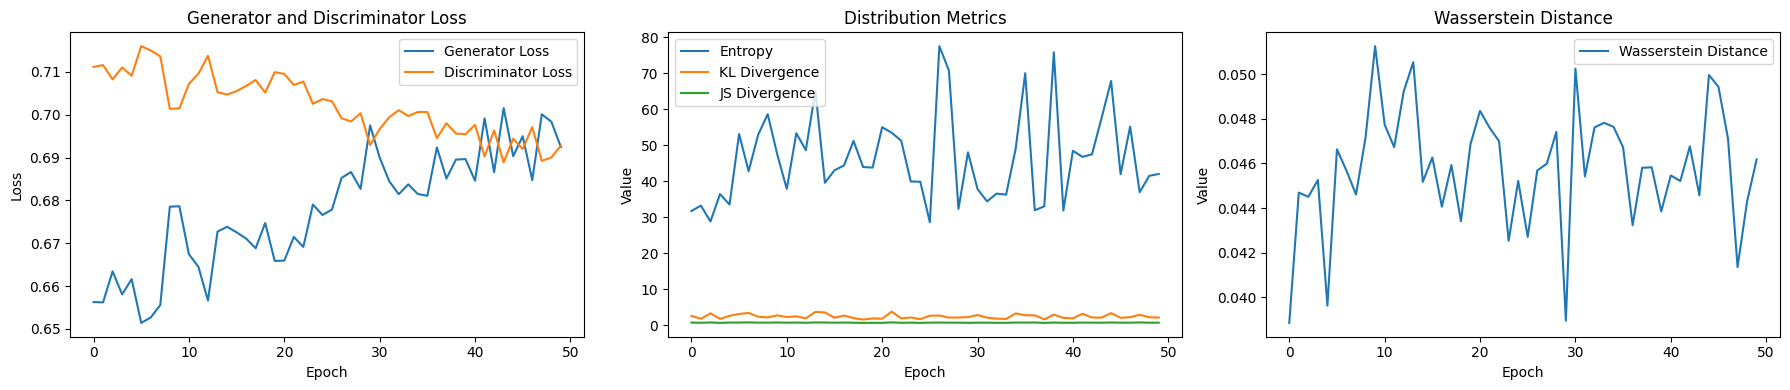

Training completed in 27.83 seconds


In [18]:
# Training loop
dim = 3
wires = num_qutrits
n_epochs = 50
num_qnn_outputs = num_discrete_values**num_dim

# Lists to store training progress
generator_loss_values = []
discriminator_loss_values = []
entropy_values = []
kl_values = []
js_values = []
wass_values = []

# Start training
start = time.time()
for epoch in range(n_epochs):
    valid = torch.ones(num_qnn_outputs, 1, dtype=torch.float)
    fake = torch.zeros(num_qnn_outputs, 1, dtype=torch.float)

    real_dist = torch.tensor(prob_data, dtype=torch.float).reshape(-1, 1)
    samples = torch.tensor(grid_elements, dtype=torch.float)
    noise = torch.randn(num_qnn_outputs, num_qutrits)
    output = generator(noise)
    _, gen_dist = qf.measure(output, index=[0, 1, 2], dim=dim, wires=wires)
    gen_dist = gen_dist.reshape(-1, 1)

    generator_optimizer.zero_grad()
    generator_loss = adversarial_loss(discriminator(samples), valid, gen_dist)
    generator_loss_values.append(generator_loss.detach().item())

    generator_loss.backward()
    generator_optimizer.step()

    discriminator_optimizer.zero_grad()
    real_loss = adversarial_loss(discriminator(samples), valid, real_dist)
    fake_loss = adversarial_loss(discriminator(samples), fake, gen_dist.detach())
    discriminator_loss = (real_loss + fake_loss) / 2

    # Store discriminator loss for plotting
    discriminator_loss_values.append(discriminator_loss.detach().item())

    discriminator_loss.backward()
    discriminator_optimizer.step()

    # Compute metrics
    # Ensure gen_dist and prob_data have the same shape
    gen_dist_np = gen_dist.detach().squeeze().numpy()
    if gen_dist_np.shape != prob_data.shape:
        gen_dist_np = gen_dist_np.reshape(prob_data.shape)
    entropy_value = entropy(gen_dist_np, prob_data)
    kl_value = np.sum(kl_div(prob_data, gen_dist_np))
    js_value = jensenshannon(prob_data, gen_dist_np)
    wass_value = wasserstein_distance(prob_data, gen_dist_np)

    # Store metrics for plotting
    entropy_values.append(entropy_value)
    kl_values.append(kl_value)
    js_values.append(js_value)
    wass_values.append(wass_value)

    # Plot training progress
    plot_training_progress()


# Training complete
elapsed = time.time() - start
print(f"Training completed in {elapsed:0.2f} seconds")

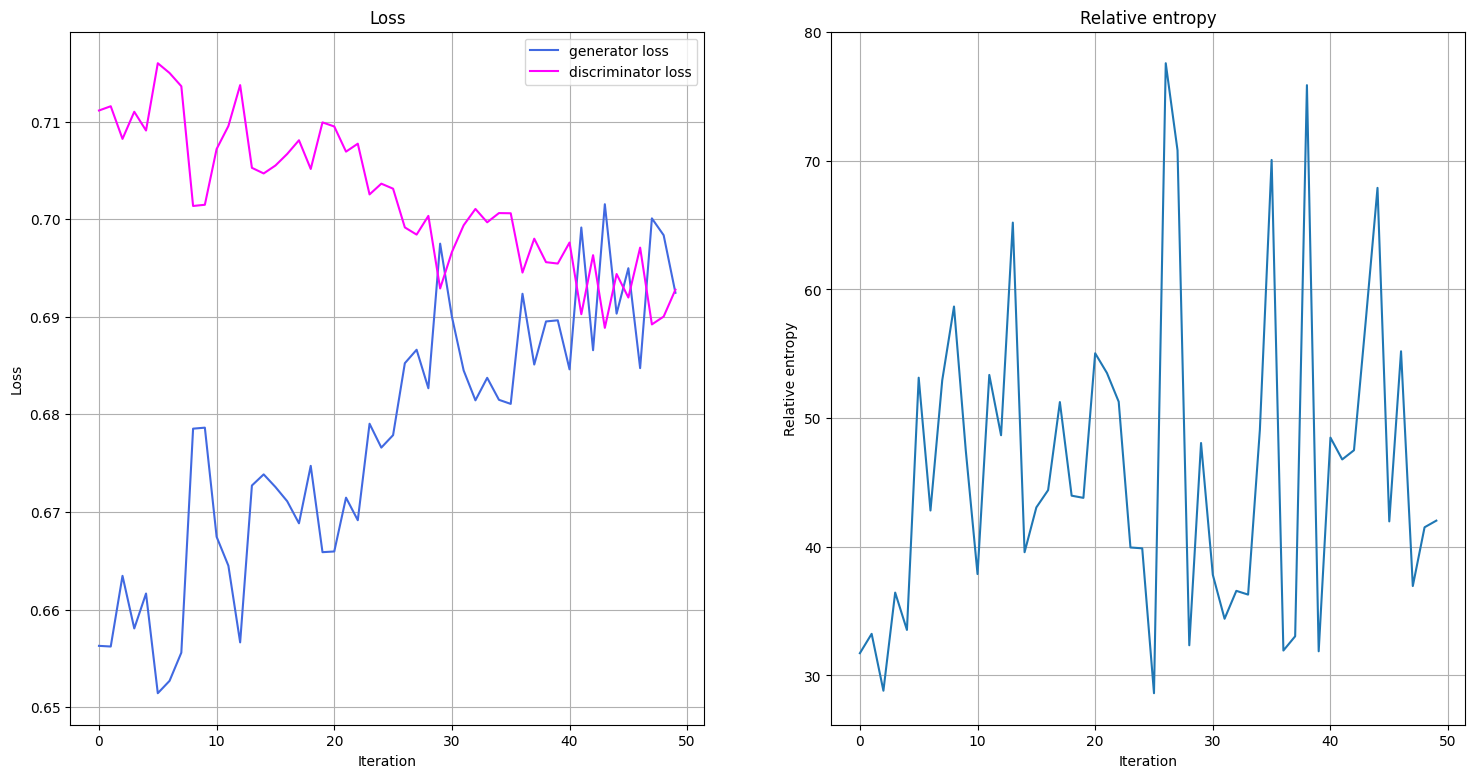

In [19]:
plot_entorpy()

In [20]:
# Al final del entrenamiento, imprime las métricas finales
print("\nMétricas Finales:")
print(f"Entropía final: {entropy_values[-1]:.4f}")
print(f"Divergencia KL final: {kl_values[-1]:.4f}")
print(f"Divergencia JS final: {js_values[-1]:.4f}")
print(f"Distancia de Wasserstein final: {wass_values[-1]:.4f}")


Métricas Finales:
Entropía final: 42.0323
Divergencia KL final: 2.0961
Divergencia JS final: 0.6831
Distancia de Wasserstein final: 0.0462
